# Human BoneMarrow

Human bonemarrow dataset used in this tutorial is acquired from [Setty et al. (2019)](https://www.nature.com/articles/s41587-019-0068-4). Bone marrow plays an crucial role in new blood cell production and contributes the generation of certain immune cells. 

This dataset can be used to detect essential parts of hematopoietic differentiation and possibly the key transcription factors that contributes to the fate choice of cells within lineage. 

As annotated in original paper, this dataset has three terminal states starting from HSCs, 1) erythroids, 2) monocytes and dendritic cells (DC) and 3) common lymphoid progenitor cells (CLP).

In [1]:
import scvelo as scv
scv.settings.verbosity = 0
import unitvelo as utv

(Running UniTVelo 0.2.5)
2024-05-29 05:02:26


In [2]:
adata = scv.datasets.bonemarrow()
adata

AnnData object with n_obs × n_vars = 5780 × 14319
    obs: 'clusters', 'palantir_pseudotime', 'assigned_t'
    uns: 'clusters_colors'
    obsm: 'X_tsne'
    layers: 'spliced', 'unspliced'

In [3]:
# dataset = '../data/BoneHuman/adata.h5ad'
dataset = './data/BoneMarrow/human_cd34_bone_marrow.h5ad'
label = 'clusters'
exp_metrics = {}

Parameter `cluster_edges` is for algorithm evaluation purpose given expert annotated ground truth. It contains a list of tuples in which stores the source cluster and target cluster of cells.

In [4]:
cluster_edges = [
    ("HSC_1", "Ery_1"), 
    ("HSC_1", "HSC_2"), 
    ("Ery_1", "Ery_2")]

## scVelo stochastic

  0%|          | 0.00/162M [00:00<?, ?B/s]

  0%|          | 0/5780 [00:00<?, ?cells/s]

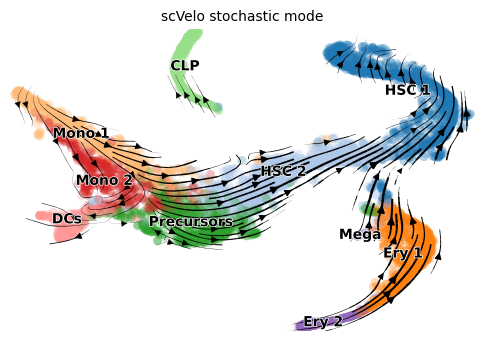

In [4]:
title = 'scVelo stochastic mode'
adata = scv.datasets.bonemarrow()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.velocity(adata, mode='stochastic')

scv.tl.velocity_graph(adata)
adata.uns['clusters_colors'] = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5']
scv.pl.velocity_embedding_stream(adata, color=label, dpi=100, title=title)

In [7]:
scv.pp.neighbors(adata)
adata_velo = adata[:, adata.var.loc[adata.var['velocity_genes'] == True].index]
exp_metrics["model_dyn"] = utv.evaluate(adata_velo, cluster_edges, label, 'velocity', 'X_tsne')

# Cross-Boundary Direction Correctness (A->B)
{('HSC_1', 'Ery_1'): -0.8610344021621074, ('HSC_1', 'HSC_2'): -0.6894453298758585, ('Ery_1', 'Ery_2'): -0.9029748019500254}
Total Mean: -0.8178181779959971
# In-cluster Coherence
{'CLP': 0.9074381, 'DCs': 0.9658171, 'Ery_1': 0.9692909, 'Ery_2': 0.9902824, 'HSC_1': 0.85452265, 'HSC_2': 0.9181577, 'Mega': 0.9639771, 'Mono_1': 0.9242185, 'Mono_2': 0.93995243, 'Precursors': 0.9324791}
Total Mean: 0.9366135597229004


## scVelo dynamic

  0%|          | 0/558 [00:00<?, ?gene/s]

  0%|          | 0/5780 [00:00<?, ?cells/s]

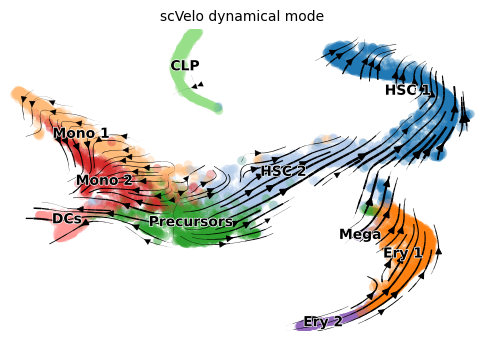

In [8]:
title = 'scVelo dynamical mode'
adata = scv.datasets.bonemarrow()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=20)
scv.tl.velocity(adata, mode='dynamical')

scv.tl.velocity_graph(adata)
adata.uns['clusters_colors'] = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5']
scv.pl.velocity_embedding_stream(adata, color=label, dpi=100, title=title)

In [9]:
scv.pp.neighbors(adata)
adata_velo = adata[:, adata.var.loc[adata.var['velocity_genes'] == True].index]
exp_metrics["model_dyn"] = utv.evaluate(adata_velo, cluster_edges, label, 'velocity', 'X_tsne')

# Cross-Boundary Direction Correctness (A->B)
{('HSC_1', 'Ery_1'): -0.8767161904580902, ('HSC_1', 'HSC_2'): -0.7406097536917645, ('Ery_1', 'Ery_2'): -0.9011676612630122}
Total Mean: -0.8394978684709556
# In-cluster Coherence
{'CLP': 0.8011706364672638, 'DCs': 0.8831685428853896, 'Ery_1': 0.968510822837128, 'Ery_2': 0.9811672009214301, 'HSC_1': 0.93928965140427, 'HSC_2': 0.9335215285774672, 'Mega': 0.9773211685600964, 'Mono_1': 0.9071636866829598, 'Mono_2': 0.9244984234425947, 'Precursors': 0.8666819017376352}
Total Mean: 0.9182493563516235


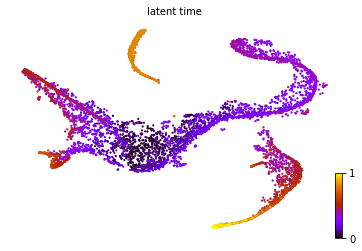

In [10]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=20)

## UniTVelo

UniTVelo requires a configuration file as input. You may sub-class it from base config file `config.py` and override the parameters you need to change (demonstrated below). For the details and comments of each parameter, please refer to `config.py`.

In [5]:
velo_config = utv.config.Configuration()

We highlight gene selection is a highly crucial step for the calculation of RNA veocity and construction of velocity graph. Though different methods have been adopted for stochastic and dynamical mode respectively, they are based on regression without offsets. \
Due to the complexity of this dataset, we use regression with offsets to select velocity genes (`velo_config.VGENES = offset`), hoping more informative genes can be included. `velo_config.R2_ADJUST` will be overridden under this setting. \
`velo_config.VGENES` has multiple options for selecting velocity genes as different combination of genes might affect the overall performance of the streamlines.

In [6]:
velo_config.VGENES = 'offset'
velo_config.R2_ADJUST = False
velo_config.IROOT = 'HSC_1'
velo_config.FIT_OPTION = '1'
velo_config.GPU = 5

------> Manully Specified Parameters <------
R2_ADJUST:	False
VGENES:	offset
IROOT:	HSC_1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
--------------------------------------------



/ssd/users/mingzegao/.conda/envs/unitvelo_atac/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


Extracted 2000 highly variable genes.
Computing moments for 2000 genes with n_neighbors: 30 and n_pcs: 30
# of velocity genes 1382 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 1203 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 1201 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.
Use diffusion pseudotime as initial.


  0%|          | 0/12000 [00:00<?, ?it/s]

adfjakjfaskjfkajfjassljf23748326482367


Loss (Total): 4507.991, (Spliced): 2284.105, (Unspliced): 2223.886: 100%|█████████▉| 11999/12000 [2:37:31<00:00,  1.27it/s]   


  0%|          | 0/5780 [00:00<?, ?cells/s]

/ssd/users/mingzegao/.conda/envs/unitvelo_atac/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/ssd/users/mingzegao/.conda/envs/unitvelo_atac/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


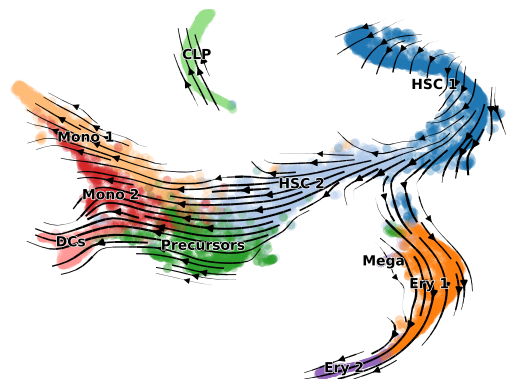

In [7]:
adata = utv.run_model('./data/BoneMarrow/human_cd34_bone_marrow.h5ad', label, config_file=velo_config)
adata.uns['clusters_colors'] = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5']
scv.pl.velocity_embedding_stream(adata, color=adata.uns['label'], dpi=100, title='')

/ssd/users/mingzegao/.conda/envs/unitvelo_atac/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


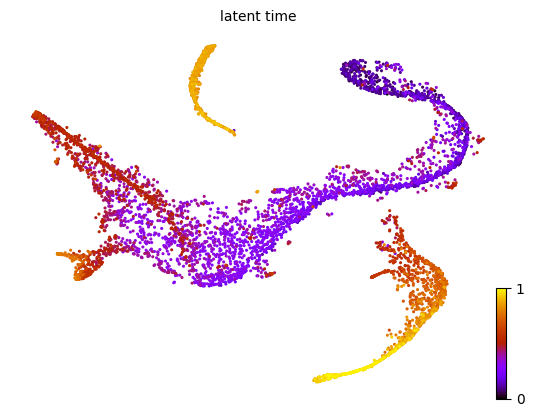

In [15]:
scv.tl.latent_time(adata, min_likelihood=None)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=20)

In [16]:
subvar = adata.var.loc[adata.var['velocity_genes'] == True]
sub = adata[:, subvar.index]

Text(0.5, 1.0, 'Peak Time')

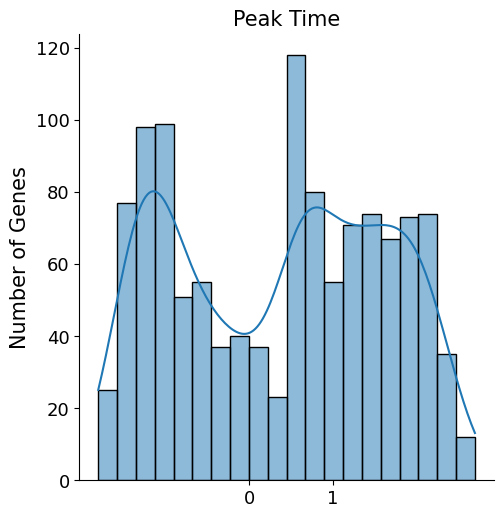

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(sub.var['fit_t'].values, kde=True, bins=20)
plt.xticks([0, 1], fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Number of Genes', fontsize=15)
plt.title('Peak Time', fontsize=15)

Here shows an example of repression gene, `CD44`. Generally the spliced counts follow a decreased manner (from upper right to lower left of the black pahse portrait), though an elevated expression can be observed in unspliced counts.

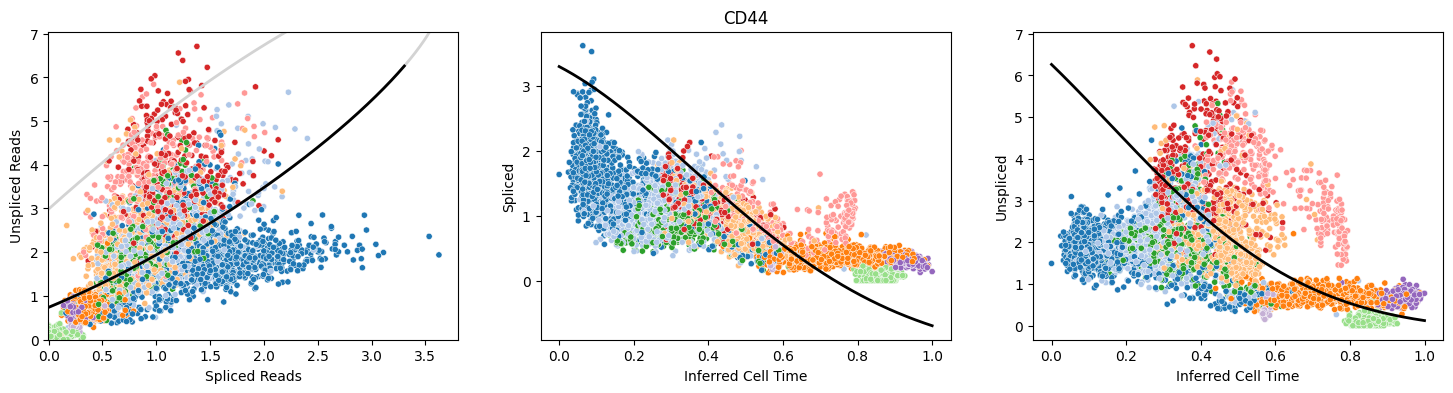

In [19]:
utv.pl.plot_range('CD44', adata, velo_config, 
    show_legend=False, show_ax=False)

/ssd/users/mingzegao/.conda/envs/unitvelo_atac/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


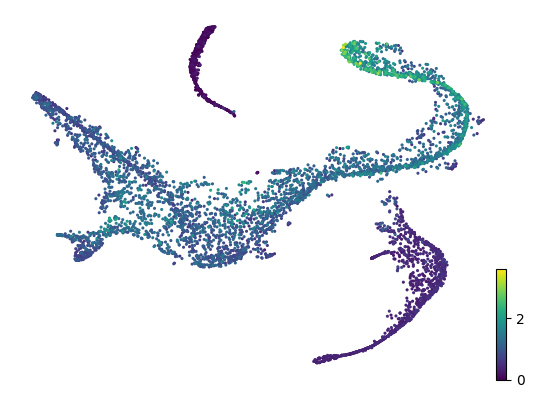

In [25]:
import numpy as np
gene_name = 'CD44'
adata.obs['temp'] = np.array(adata[:, gene_name].layers['Ms'].squeeze())
scv.pl.scatter(adata, color='temp', color_map='viridis', size=20, title='')

/ssd/users/mingzegao/.conda/envs/unitvelo_atac/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


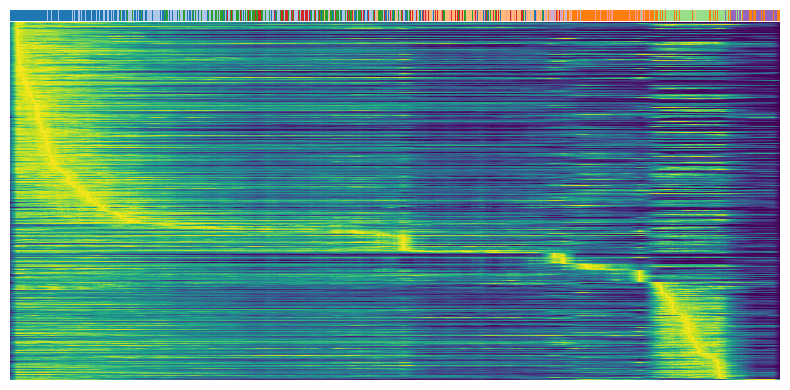

In [28]:
adata.uns['clusters_colors'] = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5']
gene = sub.var.loc[sub.var['fit_t'] < 0.05].index # repression
scv.pl.heatmap(
    adata, var_names=gene, sortby='latent_time', yticklabels=False,
    col_color=label, n_convolve=100)

/ssd/users/mingzegao/.conda/envs/unitvelo_atac/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


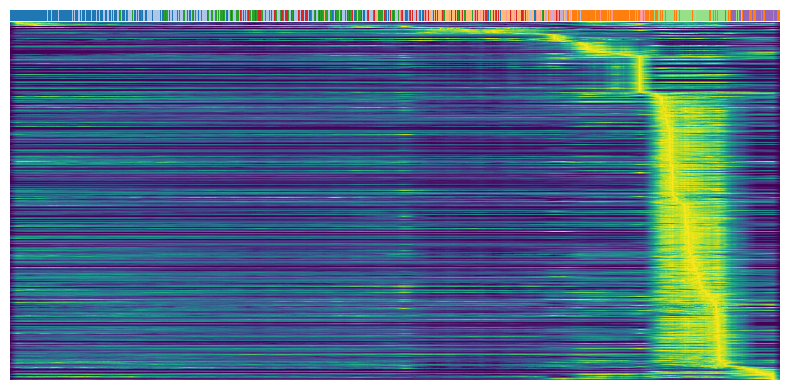

In [30]:
gene = sub.var.loc[sub.var['fit_t'] > 0.95].index # induction
scv.pl.heatmap(
    adata, var_names=gene, sortby='latent_time', yticklabels=False,
    col_color=label, n_convolve=100)